<a href="https://colab.research.google.com/github/LeonimerMelo/GANs/blob/main/Deep_Convolutional_Generative_Adversarial_Network_(DCGAN)_MNIST_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Convolutional Generative Adversarial Network (DCGAN)

Neste notebook é apresentada uma rede **GAN** usando camadas convolucionais no gerador e no discriminador. Isso é chamado de Deep Convolutional GAN, ou DCGAN para abreviar. A arquitetura DCGAN foi explorada pela primeira vez em 2016 por Alec Radford e outros, e apresentou resultados impressionantes na geração de novas imagens. Você pode ler o artigo original aqui: [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

Você treinará o DCGAN no conjunto de dados Fashion MNIST. O dataset [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) consiste em 60.000 imagens em tons de cinza para treinamento e um conjunto de teste com 10.000 imagens. Cada imagem é uma imagem em tons de cinza de 28x28 pixels, associada a um rótulo de 10 classes. O Fashion-MNIST foi criado para servir como substituto direto do dataset MNIST original para benchmark de algoritmos de aprendizado de máquina. Ele compartilha o mesmo tamanho de imagem e estrutura de divisão entre treinamento e teste.

## What are GANs?
Generative Adversarial Networks (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](https://www.tensorflow.org/tutorials/generative/images/gan1.png)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](https://www.tensorflow.org/tutorials/generative/images/gan2.png)

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

To learn more about GANs, see MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Setup

In [ ]:
import tensorflow as tf
from keras.datasets import mnist, fashion_mnist
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers, Input
import time
from IPython import display
from keras import backend

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [ ]:
# MNIST Digits dataset
#(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# MNIST Fashion dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()
print('x train shape:', x_train.shape)
# utilizo todo o banco de dados para treinamento (x_train)
x_train = np.concatenate([x_train, x_test])
print('x train shape:', x_train.shape)
print('min', x_train.min(), 'max', x_train.max())
# normalize our inputs to be in the range[-1, 1]
x_train = (x_train - 127.5) / 127.5
print('x train shape:', x_train.shape)
print('min', x_train.min(), 'max', x_train.max())
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
print('x_train tensor reshape:', x_train.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x train shape: (60000, 28, 28)
x train shape: (70000, 28, 28)
min 0 max 255
x train shape: (70000, 28, 28)
min -1.0 max 1.0
x_train tensor reshape: (70000, 28, 28, 1)


MNIST dataset visualization

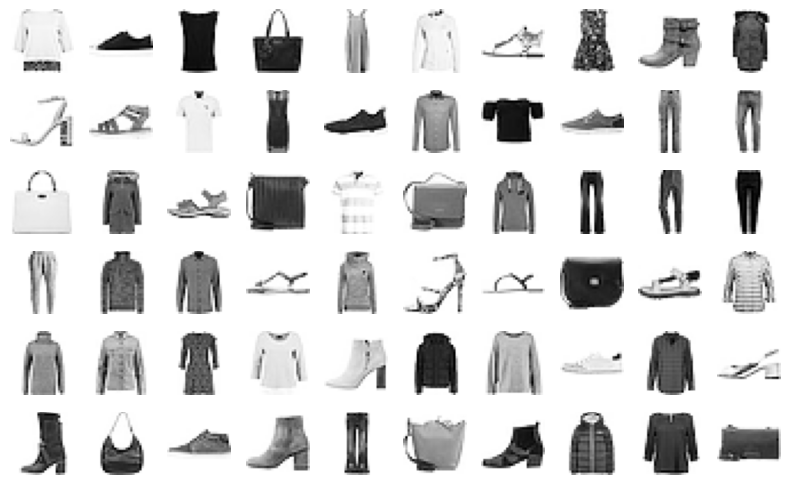

In [ ]:
# Visualização de parte do dataset
def show_data(examples):
  samples = 60
  rand_num = np.random.randint(0, examples.shape[0] - samples)
  plt.figure(figsize = (8,5))
  for i in range(samples):
    plt.subplot(6, 10, i+1)
    plt.imshow(examples[rand_num + i], cmap = 'Greys')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

show_data(x_train)

In [ ]:
BUFFER_SIZE = x_train.shape[0]
print('BUFFER_SIZE =', BUFFER_SIZE)
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

BUFFER_SIZE = 70000


## Create the models

## The Generator
Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 28x28 which is the size of our images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

<center><img src='https://drive.google.com/uc?id=1PO562Hc2W1U9LCGr3jjrvi7Tae6L7M8F' width=800></center>

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper.



<center><img src='https://drive.google.com/uc?id=1bvMHNWTqpaXIBzSFTMdMfv4kMIXB4GRo' width=800></center>

### Upsampling
**O gerador usa camadas `tf.keras.layers.Conv2DTranspose` (upsampling) para produzir uma imagem a partir de uma semente (ruído aleatório). Comece com uma camada `Dense` que recebe essa semente como entrada e, em seguida, aplique upsampling várias vezes até atingir o tamanho desejado da imagem (28x28x1). Observe a ativação `tf.keras.layers.LeakyReLU` em cada camada, exceto na camada de saída, que usa `tanh`.**  

1. **`Conv2DTranspose` (Upsampling)**  
   - Essa camada é essencial em redes geradoras (GANs), pois aumenta progressivamente a resolução espacial dos dados (ex.: transforma um vetor de ruído em uma imagem 28x28).  
   - Funciona como uma "convolução reversa", aprendendo a preencher espaços com padrões realistas.  

2. **Camada `Dense` Inicial**  
   - O gerador começa com uma camada densa para transformar o ruído aleatório (semente) em um formato que possa ser remodelado (ex.: um tensor 3D) antes do upsampling.  

3. **Ativação `LeakyReLU`**  
   - Evita o problema de "neurônios mortos" (vanishing gradients) ao permitir um pequeno gradiente para valores negativos (diferente da ReLU tradicional, que zera valores negativos).  
   - Usada em **todas as camadas exceto a última**, pois ajuda na estabilidade do treinamento.  

4. **Ativação `tanh` na Saída**  
   - A saída do gerador deve estar no intervalo `[-1, 1]` (valores normalizados), e `tanh` é ideal para isso.  
   - Se as imagens fossem normalizadas em `[0, 1]`, poderia ser usada uma ativação `sigmoid`.  

### **Diferença entre Upsampling e Conv2DTranspose**  

Ambos são usados em redes neurais (especialmente em GANs e autoencoders) para **aumentar a resolução espacial** de tensores (ex.: transformar um mapa de características pequeno em uma imagem maior). Porém, funcionam de maneiras distintas:

---

### **1. Upsampling (Simples)**  
- **O que faz?**  
  - Aumenta o tamanho da imagem ou mapa de características repetindo ou interpolando valores (ex.: bilinear, nearest-neighbor).  
  - Não aprende nada: é uma operação **fixa e determinística**.  

- **Exemplo no TensorFlow/Keras:**  
  ```python
  tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')
  ```  
  - Se a entrada for `(14, 14, 64)`, a saída será `(28, 28, 64)` (cada pixel é replicado ou interpolado).  

- **Vantagens:**  
  - Computacionalmente leve.  
  - Útil quando a relação espacial já está bem definida e só precisamos de mais resolução.  

- **Desvantagens:**  
  - Não aprende padrões complexos (pode gerar artefatos como blocos pixelados).  

---

### **2. Conv2DTranspose (Deconvolution ou Transposed Convolution)**  
- **O que faz?**  
  - Aplica uma **operação aprendida** (como uma convolução reversa) para gerar saídas maiores.  
  - Usa kernels treináveis para "preencher" os espaços vazios durante o upsampling.  

- **Exemplo no TensorFlow/Keras:**  
  ```python
  tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same')
  ```  
  - Se a entrada for `(14, 14, 128)`, a saída pode ser `(28, 28, 64)` (aumenta a resolução e reduz canais).  

- **Vantagens:**  
  - **Aprende a upsampling**: consegue gerar features mais realistas (evitando blocos pixelados).  
  - Controla o número de canais de saída (útil em redes geradoras).  

- **Desvantagens:**  
  - Mais pesada computacionalmente (tem kernels treináveis).  
  - Pode causar **artefatos em padrões de xadrez** (checkerboard artifacts) se mal configurada (ex.: strides e kernel_size não alinhados).  

---

### **Quando usar cada um?**  
| **Caso de Uso**               | **Upsampling** | **Conv2DTranspose** |  
|-------------------------------|---------------|---------------------|  
| Aumentar resolução de forma simples (ex.: autoencoders) | ✅ | ❌ |  
| Geradores de GANs (precisam de aprendizado no upsampling) | ❌ | ✅ |  
| Redes com restrição computacional | ✅ | ❌ |  
| Evitar artefatos em geradores | ❌ | ✅ (com ajustes) |  

---

### **Exemplo Prático (DCGAN)**  
Em um gerador DCGAN, **Conv2DTranspose** é preferível porque:  
1. O upsampling precisa ser **adaptativo** (o gerador deve aprender a preencher detalhes realistas).  
2. Combina bem com **BatchNorm** e **LeakyReLU** para estágios progressivos de geração.  

```python
# Upsampling convencional (menos comum em GANs modernas)
x = UpSampling2D(size=(2, 2))(x)  

# Conv2DTranspose (mais usado em GANs)
x = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)
```

---

### **Resumo**  
- **Upsampling**: Operação fixa, rápida, mas limitada.  
- **Conv2DTranspose**: Operação aprendida, flexível, mas exige mais recursos.  
- **DCGANs** quase sempre usam `Conv2DTranspose` para gerar imagens de alta qualidade.  

Para implementação de GANs, uma maneira prática é começar com `Conv2DTranspose` e ajustar os parâmetros (`strides`, `kernel_size`) para evitar checkerboard artifacts!

In [ ]:
def make_generator_model():
    backend.clear_session()
    model = tf.keras.Sequential(name='Generator')
    model.add(Input((100,)))  # Semente: ruído de 100 dimensões
    # model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.Dense(7*7*256, use_bias=False)) # Remodela para formato espacial
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.output_shape == (None, 28, 28, 1)

    return model

Generator model summary

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

### **Detalhes sobre o Código do Gerador (DCGAN)**  

Este código define a arquitetura do **gerador** de uma **Deep Convolutional GAN (DCGAN)**, responsável por transformar um vetor de ruído aleatório (`seed`) em uma imagem fake de 28x28 pixels (escala de cinza). Vamos analisar cada parte:

---

### **1. Inicialização e Camada de Entrada**  
```python
backend.clear_session()  # Limpa sessões anteriores do TF/Keras para evitar conflitos
model = tf.keras.Sequential(name='Generator')  # Modelo sequencial (camadas em ordem)
model.add(Input((100,)))  # Semente: ruído aleatório de 100 dimensões
```
- **`backend.clear_session()`**:  
  - Boa prática para evitar problemas em notebooks/Jupyter ao redefinir o modelo.  
- **`Input((100,))`**:  
  - Define a entrada como um vetor de 100 valores (latent space).  
  - Alternativamente, poderia ser feito via `input_shape=(100,)` na primeira camada `Dense`.  

---

### **2. Bloco Inicial: Dense + Reshape**  
```python
model.add(layers.Dense(7*7*256, use_bias=False))  # Expande para 7x7x256 (12544 neurônios)
model.add(layers.BatchNormalization())  # Normaliza os valores para acelerar treinamento
model.add(layers.LeakyReLU())  # Ativação não-linear (evita "neurônios mortos")
model.add(layers.Reshape((7, 7, 256)))  # Transforma em tensor 3D (7x7 com 256 canais)
```
- **`Dense(7*7*256)`**:  
  - Transforma o vetor de 100 valores em um tensor grande o suficiente para ser remodelado em 7x7x256.  
  - `use_bias=False` pois o `BatchNormalization` já ajusta a escala.  
- **`BatchNormalization`**:  
  - Estabiliza o treinamento, evitando que os gradientes explodam/desapareçam.  
- **`LeakyReLU`**:  
  - Versão "vazada" da ReLU (permite pequenos gradientes para valores negativos).  

---

### **3. Blocos de Convolução Transposta (Upsampling)**  
O gerador usa **`Conv2DTranspose`** para aumentar progressivamente a resolução da imagem:  

#### **Primeiro Bloco (7x7 → 7x7)**  
```python
model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
```
- **`Conv2DTranspose`**:  
  - **`strides=(1,1)`**: Mantém o tamanho (7x7), mas reduz canais de 256 para 128.  
  - **`padding='same'`**: Preserva dimensões espaciais.  
  - **`use_bias=False`**: Bias é redundante com BatchNorm.  

#### **Segundo Bloco (7x7 → 14x14)**  
```python
model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
```
- **`strides=(2,2)`**: Dobra a resolução (7x7 → 14x14).  
- Reduz canais para 64 (balanceia complexidade vs. detalhe).  

#### **Terceiro Bloco (14x14 → 28x28)**  
```python
model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
```
- **Saída final**:  
  - **`1` canal**: Imagem em escala de cinza.  
  - **`activation='tanh'`**: Valores de pixel entre `[-1, 1]` (compatível com pré-processamento comum em GANs).  

---

### **4. Output Shape (Verificação)**  
```python
model.output_shape == (None, 28, 28, 1)  # Formato final: (batch_size, altura, largura, canais)
```
- **`None`**: Representa o batch size (definido durante o treinamento).  
- **28x28x1**: Imagem gerada (ex.: compatível com Fashion-MNIST).  

---

### **Observações Importantes**  
1. **Ausência de `use_bias`**:  
   - Como `BatchNormalization` já ajusta escala e deslocamento, o bias se torna desnecessário.  

2. **Arquitetura DCGAN Clássica**:  
   - Segue o padrão do artigo original:  
     - **Dense → Reshape → Conv2DTranspose (com BN e LeakyReLU)**.  
   - Batchnorm **não é usado na última camada** (para evitar distorções nos pixels finais).  

3. **Alternativas/Problemas Comuns**:  
   - **Checkerboard artifacts**: Pode ocorrer se `kernel_size` e `strides` não forem bem ajustados (ex.: kernel 5x5 com strides 2x2 é uma escolha segura).  
   - **Se as imagens estiverem em `[0, 1]`**, troque `tanh` por `sigmoid`.  

---

### **Exemplo de Uso**  
```python
generator = make_generator_model()
noise = tf.random.normal([1, 100])  # Semente aleatória
generated_image = generator(noise, training=False)  # Saída: (1, 28, 28, 1)
```

Este gerador é tipicamente combinado com um **discriminador** (CNN) em uma GAN, onde ambos são treinados adversariamente.

##O Discriminador (DCGAN)
O discriminador é uma rede neural convolucional (CNN) que atua como um classificador binário, distinguindo entre imagens reais (do dataset) e falsas (geradas pelo gerador). Abaixo está a análise detalhada do código proposto:

###Arquitetura do Discriminador
O discriminador segue uma estrutura típica de CNN para classificação binária:

- Entrada: Imagem 28x28 em escala de cinza (1 canal).

- Camadas Convolucionais: Extraem features hierárquicas (bordas → texturas → padrões complexos).

- LeakyReLU: Ativação não-linear para evitar neurônios mortos.

- Camada Final: Sigmoid (probabilidade de ser real ou fake).

## **O Discriminador (DCGAN)**  

O discriminador é uma **rede neural convolucional (CNN)** que atua como um classificador binário, distinguindo entre imagens **reais** (do dataset) e **falsas** (geradas pelo gerador). Abaixo está a análise detalhada do código proposto:

---

## **1. Arquitetura do Discriminador**  
O discriminador segue uma estrutura típica de **CNN para classificação binária**:  
- **Entrada**: Imagem 28x28 em escala de cinza (1 canal).  
- **Camadas Convolucionais**: Extraem features hierárquicas (bordas → texturas → padrões complexos).  
- **LeakyReLU**: Ativação não-linear para evitar neurônios mortos.  
- **Camada Final**: Sigmoid (probabilidade de ser real ou fake).  

---

## **2. Implementação em Keras**  
```python
def make_discriminator_model():
    model = tf.keras.Sequential(name='Discriminator')
    
    # Entrada: imagem 28x28x1
    model.add(layers.Input(shape=(28, 28, 1)))
    
    # Bloco 1: Conv2D + LeakyReLU + Dropout
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))  # Alpha controla o vazamento para valores negativos
    model.add(layers.Dropout(0.3))  # Regularização para evitar overfitting
    
    # Bloco 2: Conv2D + LeakyReLU + Dropout
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Flatten + Dense (classificação)
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))  # Saída binária (0=fake, 1=real)
    
    return model
```

---

## **3. Explicação das Camadas**  

### **Bloco 1 (28x28 → 14x14)**  
- **`Conv2D(64, (5,5), strides=(2,2), padding='same')`**:  
  - Reduz a resolução pela metade (`strides=2`) e extrai 64 features.  
  - `padding='same'` mantém as bordas.  
- **`LeakyReLU(alpha=0.2)`**:  
  - Versão "vazada" da ReLU (permite pequenos gradientes negativos).  
- **`Dropout(0.3)`**:  
  - Desativa 30% dos neurônios aleatoriamente durante o treinamento (evita overfitting).  

### **Bloco 2 (14x14 → 7x7)**  
- **`Conv2D(128, (5,5), strides=(2,2))`**:  
  - Dobra o número de canais (128) e reduz a resolução para 7x7.  

### **Camada Final (Classificação)**  
- **`Flatten()`**:  
  - Transforma o tensor 3D (7x7x128) em um vetor (6272 valores).  
- **`Dense(1, activation='sigmoid')`**:  
  - Saída binária: probabilidade de a imagem ser real (1) ou fake (0).  

---

## **4. Por Que LeakyReLU e Sigmoid?**  
- **`LeakyReLU`**:  
  - Evita o problema de "neurônios mortos" (vanishing gradients) em redes profundas.  
  - **`alpha=0.2`** é um valor comum (controla o vazamento para valores negativos).  
- **`Sigmoid`**:  
  - Ideal para classificação binária (saída entre 0 e 1).  
  - Se usasse `tanh`, a saída seria entre -1 e 1, o que não faz sentido para probabilidades.  

---

## **5. Comparação com o Gerador**  
| **Componente**      | **Gerador**                          | **Discriminador**                     |  
|----------------------|--------------------------------------|---------------------------------------|  
| **Entrada**          | Vetor de ruído (100 dimensões)       | Imagem (28x28x1)                      |  
| **Camadas**          | `Conv2DTranspose` (upsampling)       | `Conv2D` (downsampling)               |  
| **Ativação**         | `LeakyReLU` + `tanh` (saída)         | `LeakyReLU` + `sigmoid` (saída)       |  
| **BatchNorm**        | Usado em todas as camadas (exceto saída) | **Não usado** (Dropout é preferido)   |  

---

## **6. Exemplo de Uso**  
```python
discriminator = make_discriminator_model()
decision = discriminator(generated_image, training=False)  # Saída: probabilidade (0 a 1)
print("Probabilidade de ser real:", decision.numpy()[0][0])
```

---

## **7. Dicas para Melhorar o Discriminador**  
1. **Adicionar mais camadas convolucionais** para capturar features mais complexas.  
2. **Ajustar o `Dropout`** (ex.: 0.5 para datasets pequenos).  
3. **Usar `BatchNorm`** (opcional, mas pode acelerar o treinamento).  
4. **Balancear o treinamento**: Se o discriminador ficar muito forte, o gerador não aprenderá.  

Este discriminador é treinado **adversarialmente** com o gerador, formando uma GAN clássica.


You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

<center><img src='https://drive.google.com/uc?id=1nXhXatz91Swz6unX3EkU72B26alI_DuX' width=800></center>

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential(name='Discriminator')
    model.add(Input([28, 28, 1]))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    # model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    #model.add(layers.Dense(1))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

Discriminator model summary

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

### **Análise Detalhada do Código do Discriminador (DCGAN)**

Este código implementa o **discriminador** de uma GAN convolucional (DCGAN), responsável por classificar imagens como "reais" (vindas do dataset) ou "falsas" (geradas pelo gerador).

---

## **1. Estrutura Geral**
```python
def make_discriminator_model():
    model = tf.keras.Sequential(name='Discriminator')
```
- **`Sequential`**: Modelo de camadas empilhadas sequencialmente.
- **`name='Discriminator'`**: Identificação clara para debug.

---

## **2. Camada de Entrada**
```python
model.add(Input([28, 28, 1]))
```
- **Formato**: Imagens 28x28 em escala de cinza (1 canal).
- **Alternativa comentada**:  
  ```python
  # model.add(layers.Conv2D(..., input_shape=[28, 28, 1]))
  ```
  - Equivalente funcional, mas menos explícito.

---

## **3. Primeiro Bloco Convolucional**
```python
model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.3))
```
- **`Conv2D`**:  
  - **64 filtros**: Número razoável para a primeira camada.  
  - **Kernel 5x5**: Tamanho balanceado para capturar padrões locais.  
  - **`strides=2`**: Reduz dimensão espacial pela metade (28x28 → 14x14).  
  - **`padding='same'`**: Mantém bordas preservadas.  
- **`LeakyReLU`**:  
  - Ativação com vazamento (`alpha=0.2` padrão) para evitar neurônios mortos.  
- **`Dropout(0.3)`**:  
  - Desativa 30% dos neurônios aleatoriamente durante o treinamento (evita *overfitting*).  

---

## **4. Segundo Bloco Convolucional**
```python
model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.3))
```
- **`128 filtros`**: Dobra a profundidade para capturar features mais complexas.  
- **Redução espacial**: 14x14 → 7x7 (devido ao `strides=2`).  
- **Dropout mantido**: Consistente com o primeiro bloco.  

---

## **5. Camadas Finais (Classificação)**
```python
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
```
- **`Flatten()`**:  
  - Transforma o tensor 3D (7x7x128) em vetor 1D (6272 valores).  
- **`Dense(1, activation='sigmoid')`**:  
  - Saída binária (0 = fake, 1 = real).  
  - **Alternativa comentada**:  
    ```python
    # model.add(layers.Dense(1))  # Sem ativação (logits)
    ```
    - Útil se você quiser usar `tf.nn.sigmoid_cross_entropy_with_logits` manualmente.  

---

## **6. Comparação com as Recomendações do DCGAN Original**
| **Característica**       | **Este Código**               | **DCGAN Paper**               |  
|--------------------------|-------------------------------|-------------------------------|  
| **Downsampling**         | Strided Conv (`strides=2`)    | Strided Conv (sem max pooling)|  
| **Batch Normalization**  | ❌ Ausente                   | ✅ Usado (exceto na 1ª camada)|  
| **Profundidade**         | 64 → 128                     | 64 → 128 → 256 (progressivo)  |  
| **Dropout**              | ✅ (0.3)                     | ❌ Não mencionado             |  

---

## **7. Pontos Fortes e Melhorias Sugeridas**
### **Pontos Fortes**:
1. **Arquitetura simples e funcional**: Adequada para datasets como Fashion-MNIST.  
2. **Dropout**: Melhora generalização.  
3. **LeakyReLU**: Evita vanishing gradients.  

### **Melhorias Possíveis**:
1. **Adicionar BatchNorm**:  
   ```python
   model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
   model.add(layers.BatchNormalization())  # Adicionar após cada Conv2D (exceto a primeira)
   model.add(layers.LeakyReLU())
   ```
   - Acelera convergência e estabiliza treinamento.  

2. **Aumentar profundidade**:  
   - Seguir padrão DCGAN (ex.: 64 → 128 → 256).  

3. **Definir `alpha` explícito no LeakyReLU**:  
   ```python
   model.add(layers.LeakyReLU(alpha=0.2))  # Valor padrão, mas explícito é melhor
   ```

4. **Camada de saída**:  
   - Manter `sigmoid` para GANs binárias, mas usar `None` + `from_logits=True` pode ser mais estável numericamente.  

---

## **8. Exemplo de Uso**
```python
discriminator = make_discriminator_model()
fake_image = generator(tf.random.normal([1, 100]))  # Imagem fake
real_image = next(iter(train_dataset))              # Imagem real

# Classificação
fake_output = discriminator(fake_image, training=True)  # ~0 (fake)
real_output = discriminator(real_image, training=True)  # ~1 (real)
```

Este discriminador é eficaz para GANs básicas, mas pode ser aprimorado seguindo as sugestões acima. A ausência de `BatchNorm` não impede o funcionamento, mas pode tornar o treinamento mais lento ou instável.

###Testing prediction
Use the (as yet untrained) generator to create an image.

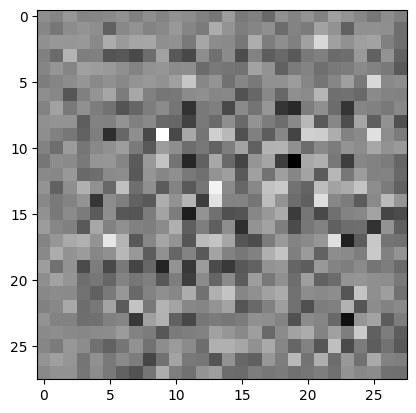

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray_r')
plt.show()

# same:
# gen_predict = generator.predict(noise)
# plt.imshow(gen_predict.reshape(28,28), cmap='gray_r')
# plt.show()

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output **one value for real images**, and **zero value for fake images**.

In [ ]:
decision = discriminator(generated_image)
print (decision)
# same result
discriminator.predict(generated_image)[0][0]

tf.Tensor([[0.49910906]], shape=(1, 1), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


np.float32(0.49910906)

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
# compute cross entropy loss
#cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
'''
For this problem from_logits = True only when the last or prediction layer of your NN
doesn't have an activation_function parameter which by default will be linear_activation.
But to avoid questions like this you could use sigmoid activation in the last Dense layer
of your NN and set from_logits = False
'''
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

Para este problema, `from_logits=True` só deve ser usado quando a última camada (ou camada de predição) da sua rede neural **não tiver um parâmetro de função de ativação** (que, por padrão, será `activation='linear'`).  
Mas para evitar dúvidas como essa, você pode:  
1. Usar **`activation='sigmoid'`** na última camada `Dense` da sua rede.  
2. Definir **`from_logits=False`** (padrão)."

---

### **Comentários Técnicos:**

#### **1. O que são `logits`?**
- **Definição**: Valores brutos (não normalizados) da saída de uma rede neural, antes de aplicar uma função de ativação (como sigmoid ou softmax).  
- **Exemplo**:  
  ```python
  # Sem ativação (logits)
  last_layer = layers.Dense(1)  # Saída: qualquer valor real (-∞, +∞)
  ```
  vs.  
  ```python
  # Com sigmoid (probabilidades)
  last_layer = layers.Dense(1, activation='sigmoid')  # Saída: (0, 1)
  ```

#### **2. Quando usar `from_logits=True`?**
- **Caso 1**: Se a última camada **não tem ativação** (ou usa `linear`), os valores são *logits*.  
  ```python
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))
  ```
- **Caso 2**: Se a última camada já aplica `sigmoid`, use `from_logits=False` (padrão).  
  ```python
  model.compile(loss=tf.keras.losses.BinaryCrossentropy())  # from_logits=False implícito
  ```

#### **3. Por que evitar `from_logits=True`?**
- **Simplicidade**: Usar `sigmoid` na última camada torna o fluxo mais intuitivo.  
- **Estabilidade numérica**:  
  - `sigmoid + from_logits=False` é numericamente estável.  
  - `logits + from_logits=True` pode ser mais preciso em alguns casos, mas exige cuidado extra.  

#### **4. Exemplo Prático:**
```python
# Modelo COM sigmoid na saída (recomendado para iniciantes)
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Saída já é probabilidade
])
model.compile(loss='binary_crossentropy')  # from_logits=False implícito

# Modelo SEM sigmoid (avançado)
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Saída é logit
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))
```

#### **5. Impacto no Treinamento:**
| **Configuração**               | **Vantagens**                          | **Desvantagens**               |  
|--------------------------------|----------------------------------------|--------------------------------|  
| `sigmoid + from_logits=False`  | Mais simples, menos propenso a erros   | Pode ter menos precisão numérica |  
| `linear + from_logits=True`    | Mais preciso numericamente             | Exige conhecimento avançado     |  

---

### **Conclusão:**
- **Para maioria dos casos**: Use `activation='sigmoid'` na última camada e `from_logits=False`.  
- **Casos avançados**: Use `from_logits=True` se precisar de controle fino sobre a estabilidade numérica.  

Essa abordagem evita confusões e garante um treinamento mais estável em problemas de classificação binária (como GANs).

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Building the GAN
<center><img src='https://drive.google.com/uc?id=1i4Zie9dNJyZEUArCkdH_7C74mzgnS2iG' width=800></center>

## Define the training loop


In [ ]:
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### **Análise da Função de Treinamento da GAN**

Esta função (`train_step`) implementa um **passo completo de treinamento** para uma GAN (Generative Adversarial Network), incluindo a atualização simultânea do gerador e do discriminador.

---

## **1. Decorador `@tf.function`**
```python
@tf.function
```
- **O que faz?**  
  - Compila a função em um grafo estático do TensorFlow, acelerando a execução (em torno de 30-50% mais rápido).  
  - Permite que o código seja executado em GPU/TPU com otimizações automáticas.  
- **Cuidado**:  
  - Variáveis externas (como `generator` ou `discriminator`) devem ser criadas antes da primeira chamada.  

---

## **2. Geração de Ruído e Forward Pass**
```python
noise = tf.random.normal([BATCH_SIZE, noise_dim])
```
- **`noise_dim`**: Dimensão do vetor latente (ex.: 100).  
- **`BATCH_SIZE`**: Número de imagens geradas por passo (ex.: 32, 64).  

```python
with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
```
- **`GradientTape`**: Monitora operações para cálculo de gradientes.  
  - Dois tapes separados para gerador e discriminador.  
- **`training=True`**:  
  - Habilita comportamentos específicos (ex.: `BatchNormalization` em modo treino).  

---

## **3. Avaliação do Discriminador**
```python
real_output = discriminator(images, training=True)
fake_output = discriminator(generated_images, training=True)
```
- **`real_output`**: Probabilidades (0 a 1) para imagens reais.  
- **`fake_output`**: Probabilidades para imagens falsas (geradas).  
- **Objetivo do discriminador**:  
  - Maximizar `real_output` (classificar reais como 1).  
  - Minimizar `fake_output` (classificar falsas como 0).  

---

## **4. Cálculo das Perdas (Losses)**
```python
gen_loss = generator_loss(fake_output)
disc_loss = discriminator_loss(real_output, fake_output)
```
- **Funções de perda típicas**:  
  - **Gerador**: Quer enganar o discriminador (alvo: `fake_output → 1`).  
    ```python
    def generator_loss(fake_output):
        return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)
    ```  
  - **Discriminador**:  
    ```python
    def discriminator_loss(real_output, fake_output):
        real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
        fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss
    ```  

---

## **5. Backpropagation e Atualização dos Pesos**
```python
gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
```
- **`tape.gradient`**: Calcula gradientes da perda em relação aos pesos treináveis.  
- **`trainable_variables`**: Lista de pesos da rede (kernels, biases, etc.).  

```python
generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
```
- **`apply_gradients`**: Atualiza pesos usando o otimizador (ex.: `Adam`).  
- **Otimizadores típicos**:  
  ```python
  generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  ```

---

## **6. Fluxo do Treinamento**
1. **Gera imagens falsas** a partir de ruído.  
2. **Classifica** imagens reais e falsas.  
3. **Calcula perdas** para ambas as redes.  
4. **Backpropagation**: Gradientes são computados.  
5. **Atualização**: Pesos são ajustados.  

---

## **7. Pontos Críticos e Melhorias**
### **Problemas Comuns**
- **Mode Collapse**: Gerador produz pouca variedade (soluções: aumentar `BATCH_SIZE`, usar *Mini-batch Discrimination*).  
- **Desbalanceamento**: Discriminador ou gerador dominam (ajustar `learning_rate` ou adicionar *Gradient Penalty*).  

### **Melhorias Sugeridas**
1. **Adicionar `tf.keras.metrics`** para monitorar perdas:  
   ```python
   gen_loss_metric.update_state(gen_loss)
   disc_loss_metric.update_state(disc_loss)
   ```  
2. **Salvar checkpoints** periódicos:  
   ```python
   if step % 1000 == 0:
       checkpoint.save(file_prefix=checkpoint_prefix)
   ```  
3. **Learning Rate Decay**:  
   ```python
   generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
   ```

---

### **Exemplo de Loop de Treinamento Completo**
```python
def train(dataset, epochs):
    for epoch in range(epochs):
        for batch in dataset:
            train_step(batch)
        # Log progresso
        print(f"Epoch {epoch}, Gen Loss: {gen_loss_metric.result()}, Disc Loss: {disc_loss_metric.result()}")
        gen_loss_metric.reset_states()
        disc_loss_metric.reset_states()
```

Esta função é o **coração do treinamento de uma GAN**, equilibrando a competição entre gerador e discriminador. A implementação segue as boas práticas do DCGAN, mas pode ser adaptada para arquiteturas mais complexas (ex.: WGAN, StyleGAN).

In [ ]:
# função para calcular o tempo de treinamento da rede
def processing_time(start_t, finish_t):
  a = finish_t - start_t
  if a < 0:
    print('Error! time negative!')
    return
  hora = 0
  min = a // 60
  seg = a % 60
  if min > 59:
    hora = min // 60
    min = min % 60
  if hora > 0:
    print("\nElapsed time:%ih%im%is"% (hora, min, seg))
  else:
    print("\nElapsed time:%im%is"% (min, seg))

Generate and save images


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray_r')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

GAN train function

In [ ]:
def train(dataset, epochs):
  start_t = time.time()
  for epoch in range(epochs):
    start_e = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    print ('Time for epoch {} is {:.2f} sec'.format(epoch + 1, time.time()-start_e))

  processing_time(start_t, time.time())

## Train the model
Call the `train()` function defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST dataset. This may take lass then a minute / epoch at GPU T4 with the default settings on Colab.

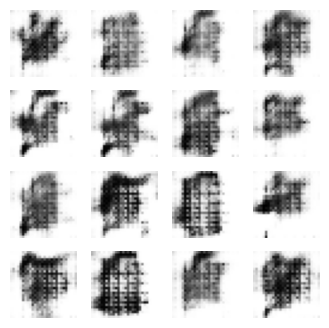

Time for epoch 10 is 13.79 sec

Elapsed time:2m13s


In [ ]:
EPOCHS = 10
train(train_dataset, EPOCHS)

In [ ]:
# função para plotar as imagens
def plot_im(images, dim=(10, 10), figsize=(10, 10)):
  plt.figure(figsize=figsize)
  for i in range(images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
    a=discr_predict[i][0]
    fo = "{:.2f}".format(a)
    plt.title(str(fo), size=10)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

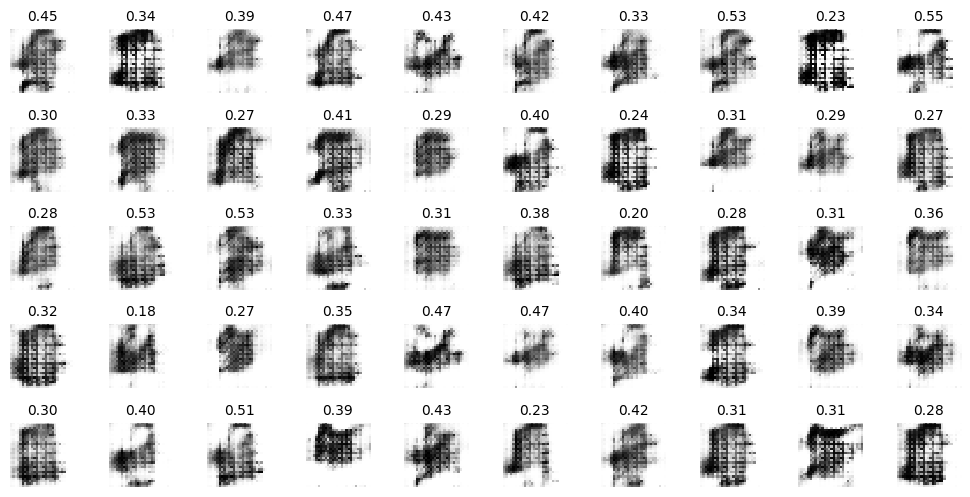

In [ ]:
# aqui vamos plotar 50 imagens fake geradas com as predições do discriminador
examples=50
noise = np.random.normal(0, 1, size=[examples, noise_dim])
generated_images = generator.predict(noise, verbose='None')
discr_predict = discriminator.predict(generated_images, verbose='None')
gen_images = generated_images.reshape(examples, 28, 28)

plot_im(gen_images)

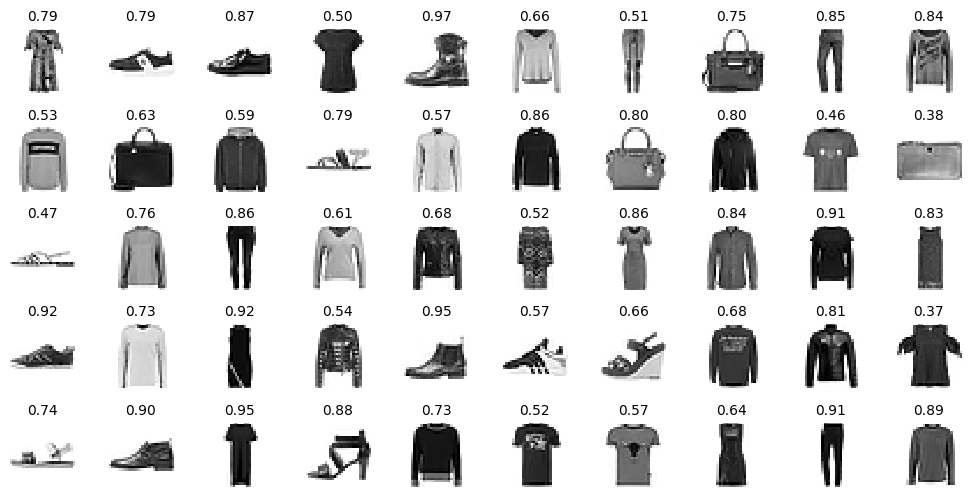

In [ ]:
# aqui vamos plotar 50 amostras das imagens reais (x_train) com as predições do discriminador
examples=50
image_batch = x_train[np.random.randint(0, x_train.shape[0], size=examples)]
discr_predict = discriminator.predict(image_batch, verbose='None')
x_images = image_batch.reshape(examples, 28, 28)

plot_im(x_images)

Display a single saved generated (fake) image

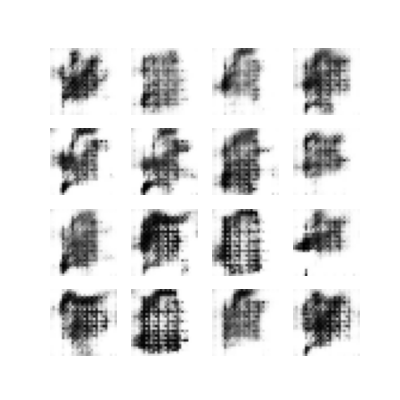

In [ ]:
# Display a single image using the epoch number
epoch_no = EPOCHS
PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

## Create a GIF


In [ ]:
# To generate GIFs
#!pip install imageio
!pip install git+https://github.com/tensorflow/docs
import imageio.v2 as imageio
import tensorflow_docs.vis.embed as embed

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-fg6bm3in
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-fg6bm3in
  Resolved https://github.com/tensorflow/docs to commit 18c3a45517af27c8513e165b8a52e6bbc1204b99
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2025.3.6.10029-py3-none-any.whl size=186351 sha256=1335b091bda8f40c39f574215f5bf005a8846866ced996de256e54c67b411f81
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ak_asr8/wheels/34/53/89/3db54cf97ce0f0261aaab3fdc12a847ea0879d34edf373e2c5
Successfully built tensorflow-docs


Use `imageio` to create an animated gif using the images saved during training.


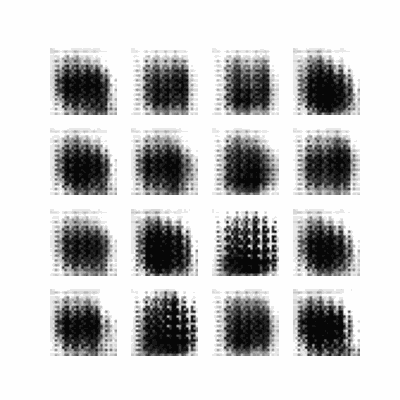

In [ ]:
if os.path.exists('dcgan.gif'):
  os.remove('dcgan.gif')
else:
  print("Start new gif picture")

anim_file = 'dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

# show animated gif
embed.embed_file(anim_file)

##Referências
[1] https://www.tensorflow.org/tutorials/generative/dcgan

[2] https://www.tensorflow.org/api_docs/python/tf/GradientTape

[3] https://arxiv.org/pdf/1511.06434.pdf

[4] [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)

[5] https://www.linkedin.com/pulse/getting-know-adam-optimization-comprehensive-guide-kiran-kumar

[6] https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

[7] https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/


##Exercícios
1. Analise e comente as linhas de código, comentando e descrevendo os comandos.
1. Altere o learning rate do otimizador e compare os resultados.
1. Explique e comente com detalhes os parâmetros de configuração do otimizador Adam utilizado neste projeto.
1. Altere os valores de beta_1 e beta_2 do otimizador Adam e verifique os resultados.
1. Altere o otimizador para RMSProp e compare os resultados.
1. Modifique o compilador inserindo o comando *metrics=['accuracy']* para coletar dados para plotar os gráficos de *loss e accuracy*.
1. Utilize o banco de dados MNIST digits e verifique o desempenho da rede.
1. Modifique a arquitetura da rede para trabalhar com imagens coloridas. Utilize o banco de dados CIFAR10 e verifque o desempenho da rede.
1. Faça uma análise comparativa entre a rede MLP utilizada no exercício anterior com a atual. Compare tempo de treinamento, acurácia, resultados finais, visualização das imagens geradas, etc. Faça uma tabela comparativa.